In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # or tensorflow, or torch

import keras
from keras import layers, ops

from sklearn.model_selection import train_test_split

from ast import literal_eval
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
arxiv_data = pd.read_csv(
    "https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv"
)
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [3]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

There are 51774 rows in the dataset.


In [4]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 12802 duplicate titles.


In [5]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 38972 rows in the deduplicated dataset.
2321
3157


In [6]:
# Filtering the rare terms.
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36651, 3)

In [7]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

In [8]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


In [9]:
# For RaggedTensor
import tensorflow as tf

terms = tf.ragged.constant(train_df["terms"].values)
lookup = layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

2025-11-03 09:59:02.498792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762160342.510120   17232 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762160342.513628   17232 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762160342.523650   17232 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762160342.523661   17232 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762160342.523663   17232 computation_placer.cc:177] computation placer alr

Vocabulary:

['[UNK]', np.str_('cs.CV'), np.str_('cs.LG'), np.str_('stat.ML'), np.str_('cs.AI'), np.str_('eess.IV'), np.str_('cs.RO'), np.str_('cs.CL'), np.str_('cs.NE'), np.str_('cs.CR'), np.str_('math.OC'), np.str_('eess.SP'), np.str_('cs.GR'), np.str_('cs.SI'), np.str_('cs.MM'), np.str_('cs.SY'), np.str_('cs.IR'), np.str_('cs.MA'), np.str_('eess.SY'), np.str_('cs.HC'), np.str_('math.IT'), np.str_('cs.IT'), np.str_('cs.DC'), np.str_('cs.CY'), np.str_('stat.AP'), np.str_('stat.TH'), np.str_('math.ST'), np.str_('stat.ME'), np.str_('eess.AS'), np.str_('cs.SD'), np.str_('q-bio.QM'), np.str_('q-bio.NC'), np.str_('cs.DS'), np.str_('cs.GT'), np.str_('cs.SE'), np.str_('cs.NI'), np.str_('cs.CG'), np.str_('I.2.6'), np.str_('stat.CO'), np.str_('math.NA'), np.str_('cs.NA'), np.str_('physics.chem-ph'), np.str_('cs.DB'), np.str_('q-bio.BM'), np.str_('cs.LO'), np.str_('cond-mat.dis-nn'), np.str_('68T45'), np.str_('math.PR'), np.str_('cs.PL'), np.str_('physics.comp-ph'), np.str_('cs.CE'), np.str_('c

2025-11-03 09:59:03.733560: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1762160343.734358   17232 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8721 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [10]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.CV', 'cs.LG']
Label-binarized representation: [[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]]


In [11]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

count    32985.000000
mean       156.380931
std         41.482839
min          5.000000
25%        128.000000
50%        154.000000
75%        183.000000
max        462.000000
Name: summaries, dtype: float64

In [12]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [13]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [14]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'Early detection of lung cancer is essential in reducing mortality. Recent\nstudies have demonstrated the clinical utility of low-dose computed tomography\n(CT) to detect lung cancer among individuals selected based on very limited\nclinical information. However, this strategy yields high false positive rates,\nwhich can lead to unnecessary and potentially harmful procedures. To address\nsuch challenges, we established a pipeline that co-learns from detailed\nclinical demographics and 3D CT images. Toward this end, we leveraged data from\nthe Consortium for Molecular and Cellular Characterization of Screen-Detected\nLesions (MCL), which focuses on early detection of lung cancer. A 3D\nattention-based deep convolutional neural net (DCNN) is proposed to identify\nlung cancer from the chest CT scan without prior anatomical location of the\nsuspicious nodule. To improve upon the non-invasive discrimination between\nbenign and malignant, we applied a random forest classifier to a

In [15]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

153351


In [16]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [17]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

Epoch 1/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - binary_accuracy: 0.9891 - loss: 0.0338 - val_binary_accuracy: 0.9940 - val_loss: 0.0198
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - binary_accuracy: 0.9989 - loss: 0.0051 - val_binary_accuracy: 0.9937 - val_loss: 0.0277
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - binary_accuracy: 0.9998 - loss: 0.0014 - val_binary_accuracy: 0.9937 - val_loss: 0.0339
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - binary_accuracy: 0.9999 - loss: 8.5085e-04 - val_binary_accuracy: 0.9936 - val_loss: 0.0379
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - binary_accuracy: 0.9999 - loss: 7.1470e-04 - val_binary_accuracy: 0.9936 - val_loss: 0.0394
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - binary_accuracy: 1.0000 - loss: 6.6544e-04 - val_binary_accuracy: 0.9936 - val_loss: 0.0414
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - binary_accuracy: 1.0000 - loss: 6.3454e-04 - val_binary_accuracy: 0.

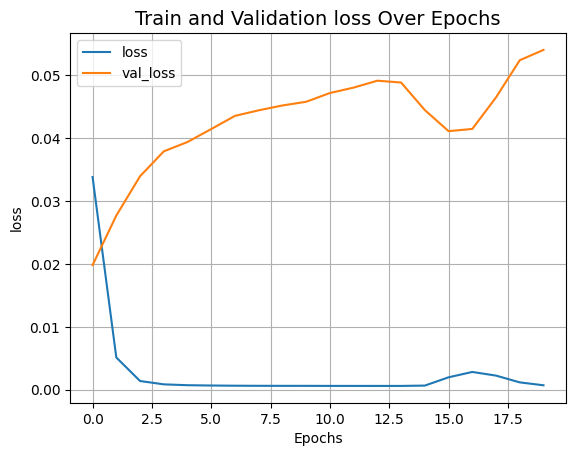

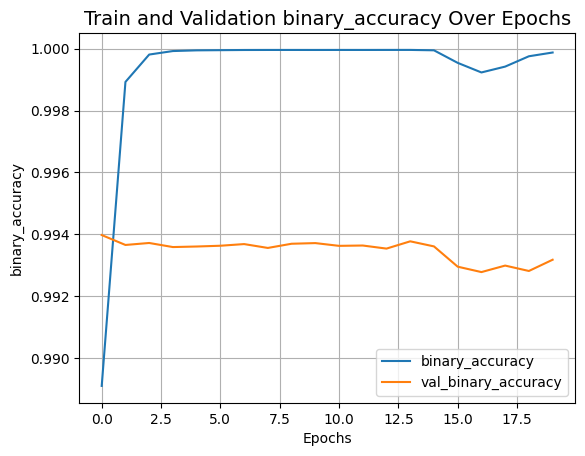

In [18]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [19]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - binary_accuracy: 0.9935 - loss: 0.0493
Categorical accuracy on the test set: 99.35%.


In [20]:
# We create a custom Model to override the predict method so
# that it first vectorizes text data
class ModelEndtoEnd(keras.Model):

    def predict(self, inputs):
        indices = text_vectorizer(inputs)
        return super().predict(indices)


def get_inference_model(model):
    inputs = shallow_mlp_model.inputs
    outputs = shallow_mlp_model.outputs
    end_to_end_model = ModelEndtoEnd(inputs, outputs, name="end_to_end_model")
    end_to_end_model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
    )
    return end_to_end_model


model_for_inference = get_inference_model(shallow_mlp_model)

# Create a small dataset just for demonstrating inference.
inference_dataset = make_dataset(test_df.sample(2), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)


# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Abstract: b'Convolutional neural network has made remarkable achievements in\nclassification of idealized point cloud, however, non-idealized point cloud\nclassification is still a challenging task. In this paper, DNDFN, namely,\nDual-Neighborhood Deep Fusion Network, is proposed to deal with this problem.\nDNDFN has two key points. One is combination of local neighborhood and global\nneigh-borhood. nearest neighbor (kNN) or ball query can capture the local\nneighborhood but ignores long-distance dependencies. A trainable neighborhood\nlearning meth-od called TN-Learning is proposed, which can capture the global\nneighborhood. TN-Learning is combined with them to obtain richer neighborhood\ninformation. The other is information transfer convolution (IT-Conv) which can\nlearn the structural information between two points and transfer features\nthrough it. Extensive exper-iments on idealized and non-idealized benchmarks\nacross four tasks verify DND